In [ ]:
# Logistic and linear regression with first order methods

Notebook to play with a few first order optimization methods. Currently covers proximal algorithms for l1 and l2 regularization as well as more recent stochastic methods like SAG and MISO. Optimization is done either on the least squares or logistic loss.

### Table of content

[1. Loss function and gradients](#loss)<br>
[2. Proximal gradient derived from a majorization-minimization method](#mm_method)<br>
[3. Proximal operators](#prox)<br>
[4. Full gradient methods (GD, ISTA, FISTA)](#full)<br>
[5. Stochastic methods (SGD, SAG, MISO, SDCA, SVRG)](#stoc)<br>
[6. Generate  dataset](#data)<br>
[7. Optimize (full gradient)](#optf)<br>

In [64]:
import numpy as np
import math
from numpy.linalg import norm

%matplotlib inline
import matplotlib.pylab as plt

from scipy.stats import bernoulli
from sklearn import linear_model
from scipy import linalg



<a id='loss'></a> 
## Loss functions and gradients

Least squares:

$$
\begin{align*}
\ell(\theta; \mathbf{x}, \mathbf{y}) = \frac{1}{2n}\sum_{i=1}^n(\theta^Tx_i - y_i)^2 \\
\frac{\partial \ell(\theta; \mathbf{x}, \mathbf{y})}{\partial\theta} = \frac{1}{n}\sum_{i=1}^n(\theta^Tx_i - y_i)x_i \\ 
\end{align*}
$$

We use 2D numpy array for `features` and `labels` to take advantage of array magic.

In [100]:
def least_squares(x, features, labels):
    """Evaluates the least square function."""
    n_samples = features.shape[0]
    x = x.reshape(1, n_features)
    loss_array = (features.dot(x.T) - labels) ** 2
    return np.sum(loss_array, axis=0) / (2. * n_samples)
def least_squares_unlab(w, X, y):
    """Evaluates the least square function."""
    n = len(y)
    N = X.shape[0]
    n_samples = features.shape[0]
    w = w.reshape(1, p)  # Added for scipy.optimize compatibility
    loss_array = (X[:n,].dot(w.T) - labels) ** 2
    return np.sum(loss_array, axis=0) / (2. * n)

In [101]:
def least_squares_grad(x, features, labels):
    """Evaluates the gradient of the least square function."""
    n_samples = features.shape[0]
    x = x.reshape(1, n_features)  # Added for scipy.optimize compatibility
    grad_array = (features.dot(x.T) - labels) * features
    return np.sum(grad_array, axis=0) / n_samples

def least_squares_unlab_grad(w, X, y):
    """Evaluates the gradient of the least square function."""
    n = len(y)
    N = X.shape[0]
    n_samples = features.shape[0]
    w = w.reshape(1, p)  # Added for scipy.optimize compatibility
    grad_array = X.dot(w.T)#* X  - y * X[:n,]
    return np.sum(grad_array, axis=0) / n

<a id='mm_method'></a> 
## Proximal gradient derived from a majorization-minimization method

Let's say we would like to minimize $f + g$, with $f: \mathbb{R}^n \rightarrow \mathbb{R}$ a convex, $\beta$-smooth function and $g$ a convex function with a simple proximal operator.

A simple upper bound on $f+g$ is:

$$
\begin{align*} 
f(y) + g(y) & \leq \{f(x) + \nabla{f(x)^T}(y - x) + \frac{1}{2\lambda}\|x-y\|_{2}^2 + g(y)\\
& = q_\lambda(x, y),
\end{align*}
$$
where $\lambda \in (0, 1/\beta]$.

Iteratively minimizing $q_\lambda(x^t, \cdot)$ will converge the minimum of $f+g$ 
$$
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\prox}{prox}
$$
$$
\begin{align*} 
\argmin_x q_\lambda(x^t, x) & = \argmin_x \{f(x^t) + \nabla{f(x^t)^T}(x - x^t) + \frac{1}{2\lambda}\|x-x^t\|_{2}^2 + g(x)\} \\ 
& = \argmin_x \{\frac{1}{2}\|x - (x^t - \lambda\nabla f(x^t))\|_2^2 + \lambda g(x)\} \\
& = \text{prox}_{\lambda g}\left(x^t - \lambda\nabla f(x^t)\right) \\
\end{align*}
$$

<a id='prox'></a> 
## Proximal operators

The derivation of the proximal operators leads to:

$$
\begin{align*}
\text{prox}_{\lambda\|\cdot\|_1}(v) & = \text{sign}(v) \odot (|v| − \lambda)_+ \\
\text{prox}_{\lambda\|\cdot\|_2^2}(v) & = \frac{1}{1 + \lambda} v \\
\text{prox}_{\lambda_1\|\cdot\|_1 + \lambda_2 / 2\|\cdot\|_2^2}(v) & = \frac{1}{1 + \lambda_2} \text{sign}(v) \odot (|v| - \lambda_1)_+
\end{align*}
$$

In [102]:
def prox_l1(x, l=1.):
    """ Proximal operator of the l1 norm."""
    x_abs = np.abs(x)
    return np.sign(x) * (x_abs - l) * (x_abs > l)

def prox_l2(x, l=1.):
    """ Proximal operator of the l2 norm."""
    return 1. / (1 + l) * x

def prox_enet(x, l_l1, l_l2, t=1.):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    prox_l1 = np.sign(x) * (x_abs - t * l_l1) * (x_abs > t * l_l1)
    return prox_l1 / (1. + t * l_l2)

<a id='full'></a> 
## Full gradient methods (GD, ISTA, FISTA)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [103]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0]  # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk)
        err = norm(xk - x_real) / norm(x_real)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
            if it[0] % (n_iter / 5) == 0:
                print ' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

And now we can implement the algorithms.

In [88]:
def gd(x_init, grad, n_iter=100, step=1., callback=None):
    """Basic gradient descent algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x -= step * grad(x)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

In [104]:
def ista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x = prox(x - step * grad(x), step)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

In [90]:
def fista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    
    for _ in range(n_iter):
        x_new = prox(y - step * grad(y), step)
        t_new = (1. + (1. + 4. * t**2)**.5) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        t = t_new
        x = x_new

        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

<a id='data'></a> 
## Generate  dataset

We test the above algorithms on a generated dataset. 

In [91]:
#dimension of \beta
p = 100
#number of labeled data
n = 50
#total number of data (labeled + unlabeled data)
N = 5000

#Data generation
proba = 0.5
X_all = bernoulli.rvs(proba, size=p*N).reshape((N, p))
X_all = 2 * X_all - 1* np.ones_like(X_all)

#Labeled data
X_lab = X_all[:n, ]

#Unlabeled Data
X_unlab = X_all[n:,]


beta_star = np.zeros(p)
#Sparsity parameter s
s = 6

noise = np.random.normal(0, 1, n)
i=1
for j in range(s) :
  i *= -1
  beta_star[j] = i *  1

#Penalty parameter
lam = math.sqrt(math.log(p)/float(n))

#Label
y = np.dot(X_lab, beta_star) + noise
X = X_all

In [92]:
# Generate a fake dataset

n_samples = 2000
n_features = 50

n = 100
p = 100
N = 1000
#p = n_features
#n = n_samples



idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
diag = np.random.rand(n_features)
features = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())

cond = 811.64


In [93]:
# Change this to 'False' to estimate the logitic regression model.
linear = True
if linear == True:
    residuals = np.random.randn(n_samples, 1)
    labels = features.dot(params.T) + residuals
else:
    labels = np.array([[float(np.random.rand() < p)] for p in logistic(features.dot(params.T))])

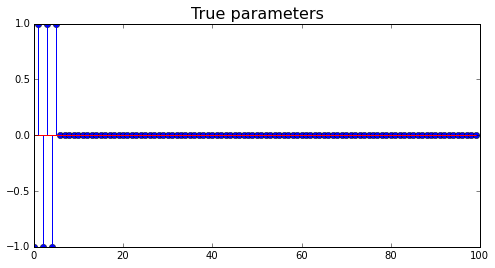

In [94]:
plt.figure(figsize=(8, 4))
plt.stem(beta_star)
plt.title("True parameters", fontsize=16)
plt.show()

<a id='optf'></a> 
## Optimize (full gradient)

### Choosing the step size

All algorithms use a constant step size set to $1/L$, where $L$ is a Lipschitz constant for the gradient of the loss.

1.Least squares

$$L = \frac{ \|\mathbf{x}^T \mathbf{x}\|_{op}}{n}$$


In [108]:
# Initialize stuff
# Intialisation of w
w = np.ones(p)
# l1 penalty parameter
alpha = lam
# l2 penalty parameter
ridge_param = 0



n_iter = 30
l_l1 = math.sqrt(math.log(p)/n)
l_l2 = 0.

# f and gradient

f = lambda w: least_squares_unlab(w, X, y)
grad_f = lambda w: least_squares_unlab_grad(w, X, y)
step = norm(X.T.dot(X) / n, 2)

# g, F and prox.
g = lambda x: l_l1 * np.abs(x).sum()
F = lambda x: f(x) + g(x)
prox_g = lambda x, l: prox_enet(x, l_l1, l_l2, l)

print "Type: %s" % ('linear' if linear else 'logistic')
print "n_iter: %d" % n_iter
print "step size: %.2f" % step

Type: linear
n_iter: 30
step size: 66.22


In [96]:
import scipy.optimize

[ 0.48580683 -0.44776072  0.67943108 -0.3082401   0.36999268 -0.29653316
  0.73223417 -0.01204372  0.2298178  -0.14414642  0.49876368 -0.19767828
  0.22170167 -0.02930128  0.12672915 -0.19703185  0.04583403 -0.00819591
  0.005524   -0.19630892  0.24310294 -0.3722018  -0.04562031 -0.1612019
 -0.15329556  0.31320519 -0.13855652 -0.05207039 -0.11342021  0.0933825
  0.00081655  0.02102726  0.03703462  0.08022761 -0.00758752  0.09012814
  0.00233852 -0.230243   -0.1951407   0.1036178  -0.02873347 -0.00235165
  0.18852208 -0.00584383 -0.02546691 -0.02694828  0.03994911 -0.32249033
  0.02509177  0.0380069 ]
[ 0.48572979 -0.44785714  0.67926269 -0.30830167  0.36993646 -0.29667514
  0.73210581 -0.01204624  0.2297471  -0.14417787  0.49864165 -0.19772117
  0.22162006 -0.02931214  0.12662097 -0.19710384  0.04581295 -0.0082795
  0.00551905 -0.19641478  0.24302609 -0.37234366 -0.04568605 -0.16131207
 -0.15342438  0.31307632 -0.13867625 -0.05209195 -0.11351108  0.09329384
  0.00081635  0.02101529  0.

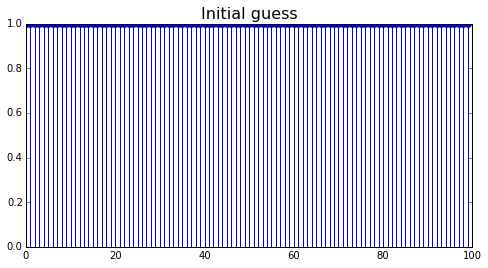

In [98]:
plt.figure(figsize=(8, 4))
plt.stem(w)
plt.title("Initial guess", fontsize=16)
plt.show()

In [109]:
# ISTA
ista_inspector = inspector(loss_fun=F, x_real=beta_star, verbose=True)
x_ista = ista(x_init, grad=grad_f, prox=prox_g, n_iter=n_iter, step=step, callback=ista_inspector)

ValueError: total size of new array must be unchanged

In [54]:
# FISTA
fista_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_fista = fista(x_init, grad=grad_f, prox=prox_g, n_iter=n_iter, step=step, callback=fista_inspector)

   it    |   obj    |   err   
       0 | 2.69e+00 | 8.95e-01
       6 | 1.17e+00 | 3.91e-01
      12 | 1.16e+00 | 3.30e-01
      18 | 1.16e+00 | 3.22e-01
      24 | 1.16e+00 | 3.23e-01


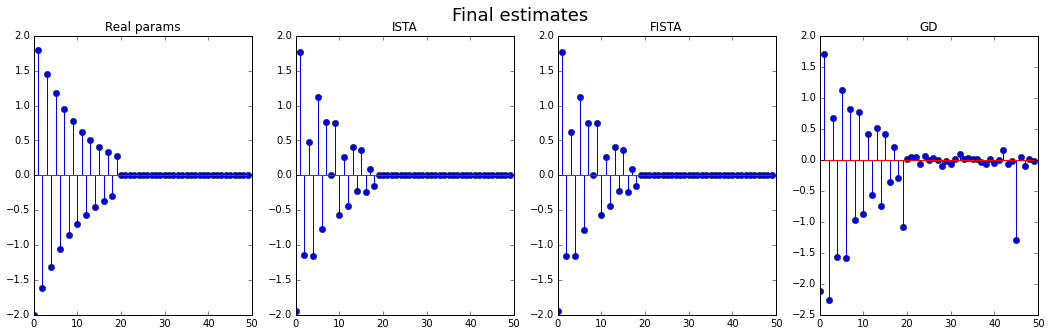

In [56]:
plt.figure(figsize=(18, 5))
plt.suptitle("Final estimates", fontsize=18)
plt.subplot(1, 4, 1)
plt.title("Real params")
plt.stem(params[0])
plt.subplot(1, 4, 2)
plt.title("ISTA")
plt.stem(x_ista[0], color='red')
plt.subplot(1, 4, 3)
plt.title("FISTA")
plt.stem(x_fista[0])
plt.subplot(1, 4, 4)
plt.title("GD")
plt.stem(x_gd[0])
plt.show()

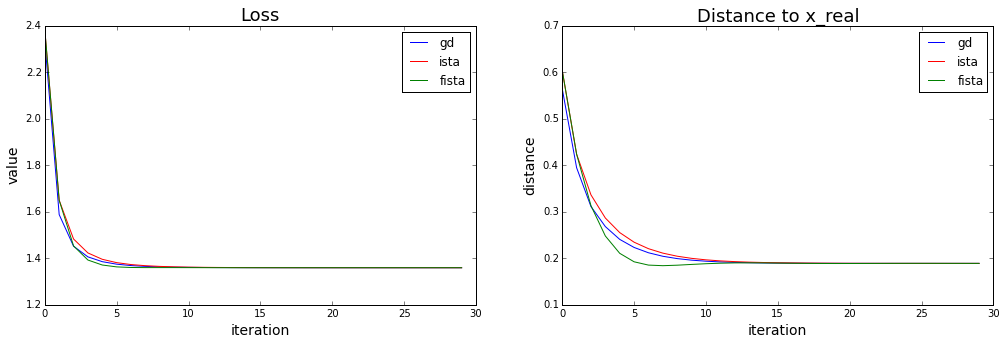

In [29]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(gd_inspector.obj, 'b')
plt.plot(ista_inspector.obj, 'r')
plt.plot(fista_inspector.obj, 'g')
plt.title("Loss", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.legend(["gd", "ista", "fista"])
plt.subplot(1, 2, 2)
plt.plot(gd_inspector.err, 'b')
plt.plot(ista_inspector.err, 'r')
plt.plot(fista_inspector.err, 'g')
plt.title("Distance to x_real", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("distance", fontsize=14)
plt.legend(["gd", "ista", "fista"])
plt.show()